In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import pandas as pd
import numpy as np
import numpyro

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/circ/biceps.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)

""" Combinations and conditions """
subjects = df.participant.unique().tolist()
subjects = [sub for sub in subjects if sub != 5]

combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x charge

conditions = encoder_dict[model.features[0]].classes_
conditions_inv = encoder_dict[model.features[0]].transform(conditions)


2023-08-09 11:59:59,949 - hbmep.config - INFO - Verifying configuration ...
2023-08-09 11:59:59,949 - hbmep.config - INFO - Success!
2023-08-09 11:59:59,962 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-08-09 11:59:59,981 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_CIRC/biceps
2023-08-09 11:59:59,982 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_CIRC/biceps
2023-08-09 11:59:59,983 - hbmep.dataset.core - INFO - Processing data ...
2023-08-09 11:59:59,984 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
conditions

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW', 'C6LE-C6LC', 'C6LE-C6LW', 'C6LN-C6LC',
       'C6LNE-C6LC', 'C6LNE-C6LSW', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LS-C6LN', 'C6LSE-C6LC', 'C6LSE-C6LNW', 'C6LSW-C6LC',
       'C6LW-C6LC'], dtype=object)

In [4]:
src = "/home/vishu/repos/hbmep-paper/reports/L_CIRC/biceps"

mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
a = mcmc[site.a].to_numpy()

a = a.reshape(-1, *a.shape[2:])

a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0))
a = a[..., 0]

d = {}

for pos in conditions_inv:
    curr_row = []
    for sub in subjects:
        if (sub, pos) in combinations:
            curr_row.append(sub)
    d[pos] = curr_row

In [5]:
mat = []

for i, i_pos in enumerate(conditions_inv):
    curr_row = []

    for j, j_pos in enumerate(conditions_inv):
        if i == j:
            curr_row.append(0)
            continue

        # Common participants
        common_ = set(d[i_pos]).intersection(set(d[j_pos]))
        common_ = list(common_)

        # print(i, j, common_)

        samples = a[:, i_pos, :] - a[:, j_pos, :]
        samples = samples[:, common_]
        samples = samples.mean(axis=-1)

        pr = (samples < 0).mean()
        curr_row.append(pr)

    mat.append(curr_row)

mat = np.array(mat)

<Axes: >

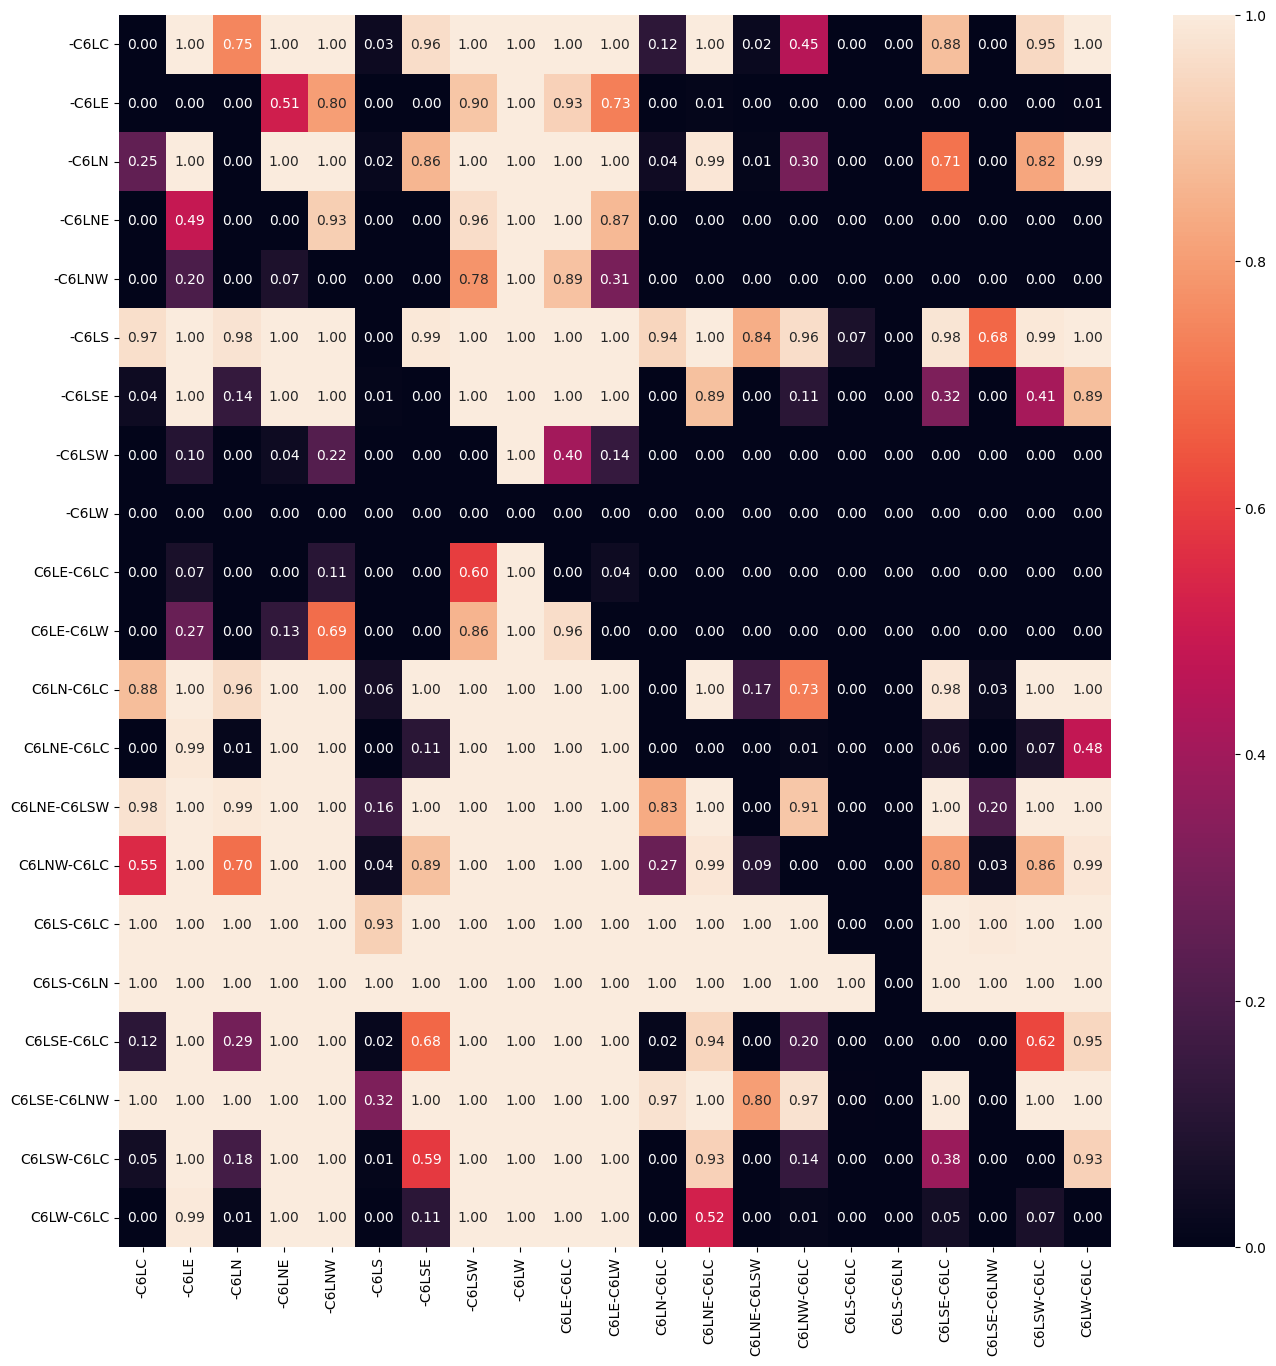

In [6]:
plt.figure(figsize=(16, 16))

sns.heatmap(mat, xticklabels=conditions, yticklabels=conditions, annot=True, fmt=".2f")


In [9]:
a.shape

(24000, 21, 8)